<a href="https://colab.research.google.com/github/priyanshusingh-collab/Image-Segmentation-using-FCN8-Architecture/blob/main/ImageSegmentation(FCN).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import zipfile
import os
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import time
import seaborn as sns
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
from tqdm import tqdm

Download the dataset and use zipfile to extract all files to '/tmp/fcnn'

In [2]:
!gdown --id 0B0d9ZiqAgFkiOHR1NTJhWVJMNEU -O /tmp/fcnn-dataset.zip
zip_file = '/tmp/fcnn-dataset.zip'
zip_p = zipfile.ZipFile(zip_file, 'r')
zip_p.extractall('/tmp/fcnn')
zip_p.close()

/usr/local/lib/python3.10/dist-packages/gdown/cli.py:121: FutureWarning: Option `--id` was deprecated in version 4.3.1 and will be removed in 5.0. You don't need to pass it anymore to use a file ID.
  warnings.warn(
Downloading...
From: https://drive.google.com/uc?id=0B0d9ZiqAgFkiOHR1NTJhWVJMNEU
To: /tmp/fcnn-dataset.zip
100% 126M/126M [00:00<00:00, 176MB/s]


**Data Preprocessing** :
The dataset contains four folders (two for training and validation images and two for their pixel maps). All images are first preprocessed by resizing to (224, 224, 3), and the pixel values are normalized between -1 and 1.
Each pixel map has a shape (height, width, 1), and a value at the pixel location indicates the class assigned to that pixel. Pixel maps are then extended from (height, width, 1) to (height, width, no_of_class) with each slice along the third axis having 1 if it belongs to the class corresponding to that slice's index else 0.
Tfds objects are then used to contain the training and validation datasets to facilitate the training process.

In [3]:
def img_preprocessing(img_path, annotation_path):

  img = tf.io.read_file(img_path)
  img = tf.image.decode_png(img)
  img = tf.image.resize(img,[224, 224])
  img = (img / 127.5) - 1

  annotation = tf.io.read_file(annotation_path)
  annotation = tf.image.decode_png(annotation)
  annotation = tf.image.resize(annotation,[224, 224])
  annotation = tf.cast(annotation, dtype=tf.int32)
  pixel_map = []
  for _ in range(12):
    pixel_map.append(tf.cast(tf.equal(annotation[:,:,0],_),dtype=tf.int32))

  pixel_map = tf.stack(pixel_map,axis=2)

  return img, pixel_map

In [4]:
def directory_to_objects(image_folder_loc, annotation_folder_loc):

  image_name_list = os.listdir(image_folder_loc)
  annotation_name_list = os.listdir(annotation_folder_loc)
  images_loc = [os.path.join(image_folder_loc,_) for _ in image_name_list]
  annotations_loc = [os.path.join(annotation_folder_loc,_) for _ in annotation_name_list]

  dataset = tf.data.Dataset.from_tensor_slices((images_loc,annotations_loc))
  dataset = dataset.map(img_preprocessing)
  return dataset

In [5]:
training_dataset = directory_to_objects("/tmp/fcnn/dataset1/images_prepped_train","/tmp/fcnn/dataset1/annotations_prepped_train")
validation_dataset = directory_to_objects("/tmp/fcnn/dataset1/images_prepped_test","/tmp/fcnn/dataset1/annotations_prepped_test")

batch_size = 64
training_dataset = training_dataset.shuffle(buffer_size=1024).batch(batch_size)
validation_dataset = validation_dataset.batch(batch_size)

class_names = ['sky', 'building','column/pole', 'road', 'side walk', 'vegetation', 'traffic light', 'fence', 'vehicle', 'pedestrian', 'byciclist', 'void']

In [6]:
colors = sns.color_palette(None, len(class_names))


for class_name, color in zip(class_names, colors):
  print(f'{class_name} -- {color}')

sky -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
building -- (1.0, 0.4980392156862745, 0.054901960784313725)
column/pole -- (0.17254901960784313, 0.6274509803921569, 0.17254901960784313)
road -- (0.8392156862745098, 0.15294117647058825, 0.1568627450980392)
side walk -- (0.5803921568627451, 0.403921568627451, 0.7411764705882353)
vegetation -- (0.5490196078431373, 0.33725490196078434, 0.29411764705882354)
traffic light -- (0.8901960784313725, 0.4666666666666667, 0.7607843137254902)
fence -- (0.4980392156862745, 0.4980392156862745, 0.4980392156862745)
vehicle -- (0.7372549019607844, 0.7411764705882353, 0.13333333333333333)
pedestrian -- (0.09019607843137255, 0.7450980392156863, 0.8117647058823529)
byciclist -- (0.12156862745098039, 0.4666666666666667, 0.7058823529411765)
void -- (1.0, 0.4980392156862745, 0.054901960784313725)


In [7]:
def give_color_to_annotation(annotation):
  '''

  '''
  seg_img = np.zeros( (annotation.shape[0],annotation.shape[1], 3) ).astype('float')

  for c in range(12):
    segc = (annotation == c)
    seg_img[:,:,0] += segc*( colors[c][0] * 255.0)
    seg_img[:,:,1] += segc*( colors[c][1] * 255.0)
    seg_img[:,:,2] += segc*( colors[c][2] * 255.0)

  return seg_img

def fuse_with_pil(images):


  widths = (image.shape[1] for image in images)
  heights = (image.shape[0] for image in images)
  total_width = sum(widths)
  max_height = max(heights)

  new_im = PIL.Image.new('RGB', (total_width, max_height))

  x_offset = 0
  for im in images:
    pil_image = PIL.Image.fromarray(np.uint8(im))
    new_im.paste(pil_image, (x_offset,0))
    x_offset += im.shape[1]

  return new_im

def show_annotation_and_image(image, annotation):

  new_ann = np.argmax(annotation, axis=2)
  seg_img = give_color_to_annotation(new_ann)

  image = image + 1
  image = image * 127.5
  image = np.uint8(image)
  images = [image, seg_img]

  images = [image, seg_img]
  fused_img = fuse_with_pil(images)
  plt.imshow(fused_img)

def list_show_annotation(dataset):

  ds = dataset.unbatch()
  ds = ds.shuffle(buffer_size=100)

  plt.figure(figsize=(25, 15))
  plt.title("Images And Annotations")
  plt.subplots_adjust(bottom=0.1, top=0.9, hspace=0.05)

  # we set the number of image-annotation pairs to 9
  # feel free to make this a function parameter if you want
  for idx, (image, annotation) in enumerate(ds.take(9)):
    plt.subplot(3, 3, idx + 1)
    plt.yticks([])
    plt.xticks([])
    show_annotation_and_image(image.numpy(), annotation.numpy())

def show_predictions(image, labelmaps, titles, iou_list, dice_score_list):


  true_img = give_color_to_annotation(labelmaps[1])
  pred_img = give_color_to_annotation(labelmaps[0])

  image = image + 1
  image = image * 127.5
  images = np.uint8([image, pred_img, true_img])

  metrics_by_id = [(idx, iou, dice_score) for idx, (iou, dice_score) in enumerate(zip(iou_list, dice_score_list)) if iou > 0.0]
  metrics_by_id.sort(key=lambda tup: tup[1], reverse=True)  # sorts in place

  display_string_list = ["{}: IOU: {} Dice Score: {}".format(class_names[idx], iou, dice_score) for idx, iou, dice_score in metrics_by_id]
  display_string = "\n\n".join(display_string_list)

  plt.figure(figsize=(15, 4))

  for idx, im in enumerate(images):
    plt.subplot(1, 3, idx+1)
    if idx == 1:
      plt.xlabel(display_string)
    plt.xticks([])
    plt.yticks([])
    plt.title(titles[idx], fontsize=12)
    plt.imshow(im)

<ipython-input-7-1707ec2c29d1>:87: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3, 3, idx + 1)


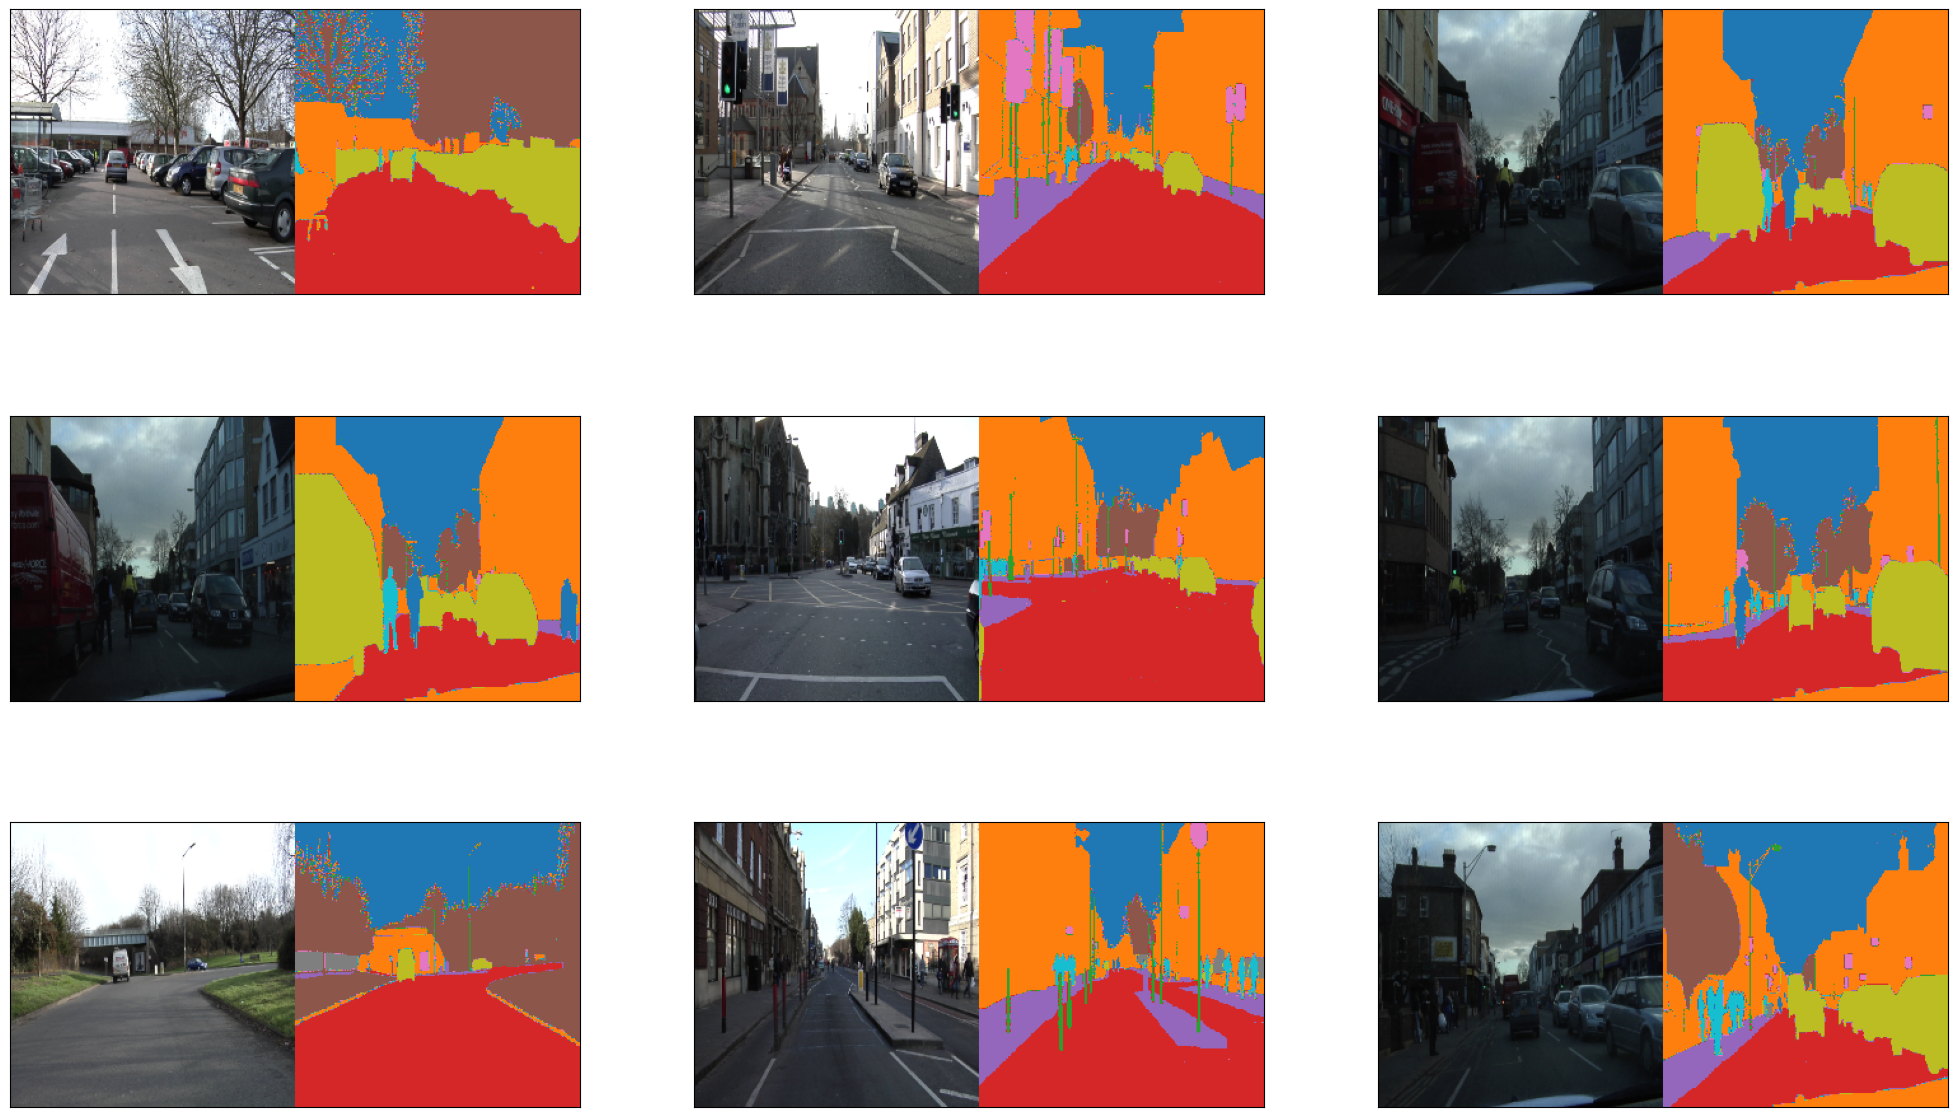

In [8]:
list_show_annotation(training_dataset)

**Define the Model:**
For this segmentation problem, a fully convolutional network with encoder 8 has been utilized. For the encoder part, the VGG_16 model has been used to obtain the downsampled feature map. Then, the output of the encoder is upscaled by a factor of two using transposed convolution and added to the applied 1x1 convolution of the output of the fourth max pooling layer, and a similar operation is performed between the new output and the output of the third max pooling layer.

In [9]:
def vgg_block(input, no_of_convlayers, no_of_filters, kernel_size, activation, pool_size, pool_stride, strides=1):

  x = input
  for _ in range(no_of_convlayers):
    x = tf.keras.layers.Conv2D(filters=no_of_filters, kernel_size=kernel_size, strides=strides, activation=activation, padding='same')(x)

  x = tf.keras.layers.MaxPooling2D(pool_size, strides=pool_stride)(x)
  return x

In [10]:
def VGG_16(image_input):


  x = vgg_block(image_input, 2, 64, (3,3), 'relu',(2,2), (2,2))
  p1= x
  x = vgg_block(x, 2, 128, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2))
  p2 = x
  x = vgg_block(x, 3,  256, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2))
  p3 = x
  x = vgg_block(x, 3, 512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2))
  p4 = x
  x = vgg_block(x, 3, 512, kernel_size=(3,3), activation='relu',pool_size=(2,2), pool_stride=(2,2))
  p5 = x
  c6 = tf.keras.layers.Conv2D(4096 , ( 7 , 7 ) , activation='relu' , padding='same')(p5)
  c7 = tf.keras.layers.Conv2D(4096, ( 1 , 1 ) , activation='relu' , padding='same')(c6)


  return (p1, p2, p3, p4, c7)

In [11]:
def fcn8_decoder(convs, n_classes):



  f1, f2, f3, f4, f5 = convs


  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False )(f5)
  o = tf.keras.layers.Cropping2D(cropping=(1,1))(o)
  o2 = f4
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)
  o = tf.keras.layers.Add()([o, o2])
  o = (tf.keras.layers.Conv2DTranspose( n_classes , kernel_size=(4,4) ,  strides=(2,2) , use_bias=False ))(o)
  o = tf.keras.layers.Cropping2D(cropping=(1, 1))(o)
  o2 = f3
  o2 = ( tf.keras.layers.Conv2D(n_classes , ( 1 , 1 ) , activation='relu' , padding='same'))(o2)
  o = tf.keras.layers.Add()([o, o2])
  o = tf.keras.layers.Conv2DTranspose(n_classes , kernel_size=(8,8) ,  strides=(8,8) , use_bias=False )(o)
  o = (tf.keras.layers.Activation('softmax'))(o)

  return o

In [12]:
inputs = tf.keras.layers.Input(shape=(224,224,3,))
convs = VGG_16(image_input=inputs)
outputs = fcn8_decoder(convs, 12)
model = tf.keras.Model(inputs=inputs, outputs=outputs)

In [13]:
adam = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()
model.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                           

For model training, Gradient Tape API is utilized to fit the data into the model.

In [14]:
overall_training_loss = []
overall_validation_loss = []
epochs=150
for epoch in range(epochs):

  training_loss_history = []
  validation_loss_history = []
  for x,y in tqdm(training_dataset):

    with tf.GradientTape() as tape:
      y_hat = model(x)
      loss_value = loss(y, y_hat)
    gradients = tape.gradient(loss_value, model.trainable_weights)
    adam.apply_gradients(zip(gradients, model.trainable_weights))
    training_loss_history.append(loss_value)
    overall_training_loss.append(loss_value)

  for x,y in validation_dataset:
    y_hat = model(x)
    val_loss = loss(y,y_hat)
    validation_loss_history.append(val_loss)
    overall_validation_loss.append(val_loss)


  print("Epoch : {}  |  Current Training Loss {}  | Current Validation Loss {}".format(epoch+1, round(float(np.mean(training_loss_history)),3), round(float(np.mean(validation_loss_history)),3)))




100%|██████████| 6/6 [02:01<00:00, 20.22s/it]


Epoch : 1  |  Current Training Loss 2.477  | Current Validation Loss 2.462


100%|██████████| 6/6 [00:13<00:00,  2.22s/it]


Epoch : 2  |  Current Training Loss 2.445  | Current Validation Loss 2.395


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch : 3  |  Current Training Loss 2.413  | Current Validation Loss 2.279


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch : 4  |  Current Training Loss 2.301  | Current Validation Loss 2.203


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 5  |  Current Training Loss 2.178  | Current Validation Loss 2.134


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 6  |  Current Training Loss 2.044  | Current Validation Loss 2.016


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 7  |  Current Training Loss 1.883  | Current Validation Loss 1.894


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch : 8  |  Current Training Loss 1.746  | Current Validation Loss 1.793


100%|██████████| 6/6 [00:13<00:00,  2.31s/it]


Epoch : 9  |  Current Training Loss 1.635  | Current Validation Loss 1.723


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 10  |  Current Training Loss 1.511  | Current Validation Loss 1.658


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch : 11  |  Current Training Loss 1.402  | Current Validation Loss 1.501


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 12  |  Current Training Loss 1.26  | Current Validation Loss 1.389


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 13  |  Current Training Loss 1.242  | Current Validation Loss 1.288


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch : 14  |  Current Training Loss 1.108  | Current Validation Loss 1.135


100%|██████████| 6/6 [00:13<00:00,  2.27s/it]


Epoch : 15  |  Current Training Loss 1.027  | Current Validation Loss 1.088


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 16  |  Current Training Loss 0.986  | Current Validation Loss 1.089


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 17  |  Current Training Loss 0.957  | Current Validation Loss 1.047


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 18  |  Current Training Loss 0.929  | Current Validation Loss 1.042


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 19  |  Current Training Loss 0.908  | Current Validation Loss 1.052


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 20  |  Current Training Loss 0.886  | Current Validation Loss 1.03


100%|██████████| 6/6 [00:13<00:00,  2.25s/it]


Epoch : 21  |  Current Training Loss 0.871  | Current Validation Loss 0.993


100%|██████████| 6/6 [00:13<00:00,  2.24s/it]


Epoch : 22  |  Current Training Loss 0.852  | Current Validation Loss 0.983


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 23  |  Current Training Loss 0.838  | Current Validation Loss 0.947


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 24  |  Current Training Loss 0.821  | Current Validation Loss 0.948


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 25  |  Current Training Loss 0.855  | Current Validation Loss 1.258


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 26  |  Current Training Loss 0.908  | Current Validation Loss 0.969


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch : 27  |  Current Training Loss 0.873  | Current Validation Loss 0.926


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch : 28  |  Current Training Loss 0.834  | Current Validation Loss 0.963


100%|██████████| 6/6 [00:13<00:00,  2.26s/it]


Epoch : 29  |  Current Training Loss 0.82  | Current Validation Loss 0.851


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Epoch : 30  |  Current Training Loss 0.796  | Current Validation Loss 0.875


100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


Epoch : 31  |  Current Training Loss 0.762  | Current Validation Loss 0.811


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 32  |  Current Training Loss 0.735  | Current Validation Loss 0.766


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch : 33  |  Current Training Loss 0.714  | Current Validation Loss 0.739


100%|██████████| 6/6 [00:13<00:00,  2.32s/it]


Epoch : 34  |  Current Training Loss 0.703  | Current Validation Loss 0.727


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch : 35  |  Current Training Loss 0.677  | Current Validation Loss 0.736


100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


Epoch : 36  |  Current Training Loss 0.652  | Current Validation Loss 0.714


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 37  |  Current Training Loss 0.636  | Current Validation Loss 0.757


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 38  |  Current Training Loss 0.628  | Current Validation Loss 0.77


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch : 39  |  Current Training Loss 0.605  | Current Validation Loss 0.74


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 40  |  Current Training Loss 0.589  | Current Validation Loss 0.69


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch : 41  |  Current Training Loss 0.564  | Current Validation Loss 0.688


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch : 42  |  Current Training Loss 0.547  | Current Validation Loss 0.684


100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


Epoch : 43  |  Current Training Loss 0.526  | Current Validation Loss 0.68


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch : 44  |  Current Training Loss 0.509  | Current Validation Loss 0.72


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 45  |  Current Training Loss 0.489  | Current Validation Loss 0.713


100%|██████████| 6/6 [00:12<00:00,  2.03s/it]


Epoch : 46  |  Current Training Loss 0.469  | Current Validation Loss 0.678


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch : 47  |  Current Training Loss 0.453  | Current Validation Loss 0.708


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 48  |  Current Training Loss 0.438  | Current Validation Loss 0.723


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch : 49  |  Current Training Loss 0.431  | Current Validation Loss 0.689


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch : 50  |  Current Training Loss 0.425  | Current Validation Loss 0.711


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 51  |  Current Training Loss 0.412  | Current Validation Loss 0.691


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 52  |  Current Training Loss 0.403  | Current Validation Loss 0.648


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch : 53  |  Current Training Loss 0.393  | Current Validation Loss 0.705


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 54  |  Current Training Loss 0.383  | Current Validation Loss 0.669


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 55  |  Current Training Loss 0.377  | Current Validation Loss 0.714


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 56  |  Current Training Loss 0.366  | Current Validation Loss 0.653


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 57  |  Current Training Loss 0.357  | Current Validation Loss 0.655


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 58  |  Current Training Loss 0.35  | Current Validation Loss 0.659


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 59  |  Current Training Loss 0.344  | Current Validation Loss 0.666


100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


Epoch : 60  |  Current Training Loss 0.339  | Current Validation Loss 0.682


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 61  |  Current Training Loss 0.334  | Current Validation Loss 0.645


100%|██████████| 6/6 [00:14<00:00,  2.40s/it]


Epoch : 62  |  Current Training Loss 0.331  | Current Validation Loss 0.707


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 63  |  Current Training Loss 0.328  | Current Validation Loss 0.657


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 64  |  Current Training Loss 0.321  | Current Validation Loss 0.718


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 65  |  Current Training Loss 0.321  | Current Validation Loss 0.706


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 66  |  Current Training Loss 0.314  | Current Validation Loss 0.703


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch : 67  |  Current Training Loss 0.309  | Current Validation Loss 0.712


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch : 68  |  Current Training Loss 0.305  | Current Validation Loss 0.669


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 69  |  Current Training Loss 0.3  | Current Validation Loss 0.703


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 70  |  Current Training Loss 0.294  | Current Validation Loss 0.723


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 71  |  Current Training Loss 0.291  | Current Validation Loss 0.703


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 72  |  Current Training Loss 0.286  | Current Validation Loss 0.726


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 73  |  Current Training Loss 0.286  | Current Validation Loss 0.742


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 74  |  Current Training Loss 0.284  | Current Validation Loss 0.73


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch : 75  |  Current Training Loss 0.281  | Current Validation Loss 0.721


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 76  |  Current Training Loss 0.28  | Current Validation Loss 0.726


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch : 77  |  Current Training Loss 0.277  | Current Validation Loss 0.745


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch : 78  |  Current Training Loss 0.275  | Current Validation Loss 0.733


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch : 79  |  Current Training Loss 0.273  | Current Validation Loss 0.755


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 80  |  Current Training Loss 0.272  | Current Validation Loss 0.773


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 81  |  Current Training Loss 0.271  | Current Validation Loss 0.748


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 82  |  Current Training Loss 0.27  | Current Validation Loss 0.74


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 83  |  Current Training Loss 0.269  | Current Validation Loss 0.718


100%|██████████| 6/6 [00:14<00:00,  2.34s/it]


Epoch : 84  |  Current Training Loss 0.271  | Current Validation Loss 0.728


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch : 85  |  Current Training Loss 0.268  | Current Validation Loss 0.759


100%|██████████| 6/6 [00:12<00:00,  2.09s/it]


Epoch : 86  |  Current Training Loss 0.265  | Current Validation Loss 0.714


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 87  |  Current Training Loss 0.262  | Current Validation Loss 0.757


100%|██████████| 6/6 [00:12<00:00,  2.07s/it]


Epoch : 88  |  Current Training Loss 0.257  | Current Validation Loss 0.759


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 89  |  Current Training Loss 0.255  | Current Validation Loss 0.758


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 90  |  Current Training Loss 0.252  | Current Validation Loss 0.748


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 91  |  Current Training Loss 0.248  | Current Validation Loss 0.758


100%|██████████| 6/6 [00:13<00:00,  2.21s/it]


Epoch : 92  |  Current Training Loss 0.247  | Current Validation Loss 0.757


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 93  |  Current Training Loss 0.245  | Current Validation Loss 0.794


100%|██████████| 6/6 [00:12<00:00,  2.16s/it]


Epoch : 94  |  Current Training Loss 0.244  | Current Validation Loss 0.782


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 95  |  Current Training Loss 0.244  | Current Validation Loss 0.815


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch : 96  |  Current Training Loss 0.247  | Current Validation Loss 0.825


100%|██████████| 6/6 [00:13<00:00,  2.19s/it]


Epoch : 97  |  Current Training Loss 0.271  | Current Validation Loss 0.803


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Epoch : 98  |  Current Training Loss 0.313  | Current Validation Loss 0.719


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch : 99  |  Current Training Loss 0.301  | Current Validation Loss 0.709


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch : 100  |  Current Training Loss 0.282  | Current Validation Loss 0.712


100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


Epoch : 101  |  Current Training Loss 0.265  | Current Validation Loss 0.711


100%|██████████| 6/6 [00:11<00:00,  1.99s/it]


Epoch : 102  |  Current Training Loss 0.253  | Current Validation Loss 0.724


100%|██████████| 6/6 [00:20<00:00,  3.42s/it]


Epoch : 103  |  Current Training Loss 0.246  | Current Validation Loss 0.727


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 104  |  Current Training Loss 0.239  | Current Validation Loss 0.721


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 105  |  Current Training Loss 0.234  | Current Validation Loss 0.759


100%|██████████| 6/6 [00:14<00:00,  2.39s/it]


Epoch : 106  |  Current Training Loss 0.232  | Current Validation Loss 0.774


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch : 107  |  Current Training Loss 0.228  | Current Validation Loss 0.781


100%|██████████| 6/6 [00:12<00:00,  2.12s/it]


Epoch : 108  |  Current Training Loss 0.226  | Current Validation Loss 0.799


100%|██████████| 6/6 [00:12<00:00,  2.06s/it]


Epoch : 109  |  Current Training Loss 0.224  | Current Validation Loss 0.831


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 110  |  Current Training Loss 0.223  | Current Validation Loss 0.81


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 111  |  Current Training Loss 0.221  | Current Validation Loss 0.826


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 112  |  Current Training Loss 0.219  | Current Validation Loss 0.846


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 113  |  Current Training Loss 0.218  | Current Validation Loss 0.85


100%|██████████| 6/6 [00:12<00:00,  2.14s/it]


Epoch : 114  |  Current Training Loss 0.218  | Current Validation Loss 0.842


100%|██████████| 6/6 [00:13<00:00,  2.29s/it]


Epoch : 115  |  Current Training Loss 0.218  | Current Validation Loss 0.85


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 116  |  Current Training Loss 0.218  | Current Validation Loss 0.859


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 117  |  Current Training Loss 0.217  | Current Validation Loss 0.851


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 118  |  Current Training Loss 0.218  | Current Validation Loss 0.827


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 119  |  Current Training Loss 0.218  | Current Validation Loss 0.86


100%|██████████| 6/6 [00:12<00:00,  2.11s/it]


Epoch : 120  |  Current Training Loss 0.218  | Current Validation Loss 0.841


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch : 121  |  Current Training Loss 0.218  | Current Validation Loss 0.831


100%|██████████| 6/6 [00:12<00:00,  2.10s/it]


Epoch : 122  |  Current Training Loss 0.216  | Current Validation Loss 0.87


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 123  |  Current Training Loss 0.214  | Current Validation Loss 0.84


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 124  |  Current Training Loss 0.215  | Current Validation Loss 0.884


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch : 125  |  Current Training Loss 0.213  | Current Validation Loss 0.855


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 126  |  Current Training Loss 0.214  | Current Validation Loss 0.836


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 127  |  Current Training Loss 0.214  | Current Validation Loss 0.84


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 128  |  Current Training Loss 0.214  | Current Validation Loss 0.865


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 129  |  Current Training Loss 0.212  | Current Validation Loss 0.861


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 130  |  Current Training Loss 0.21  | Current Validation Loss 0.86


100%|██████████| 6/6 [00:12<00:00,  2.08s/it]


Epoch : 131  |  Current Training Loss 0.209  | Current Validation Loss 0.856


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 132  |  Current Training Loss 0.208  | Current Validation Loss 0.866


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 133  |  Current Training Loss 0.206  | Current Validation Loss 0.868


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 134  |  Current Training Loss 0.206  | Current Validation Loss 0.868


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch : 135  |  Current Training Loss 0.205  | Current Validation Loss 0.899


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 136  |  Current Training Loss 0.205  | Current Validation Loss 0.878


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 137  |  Current Training Loss 0.206  | Current Validation Loss 0.87


100%|██████████| 6/6 [00:13<00:00,  2.17s/it]


Epoch : 138  |  Current Training Loss 0.206  | Current Validation Loss 0.878


100%|██████████| 6/6 [00:14<00:00,  2.38s/it]


Epoch : 139  |  Current Training Loss 0.206  | Current Validation Loss 0.87


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 140  |  Current Training Loss 0.205  | Current Validation Loss 0.881


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 141  |  Current Training Loss 0.204  | Current Validation Loss 0.865


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 142  |  Current Training Loss 0.203  | Current Validation Loss 0.908


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 143  |  Current Training Loss 0.202  | Current Validation Loss 0.879


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 144  |  Current Training Loss 0.201  | Current Validation Loss 0.9


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 145  |  Current Training Loss 0.2  | Current Validation Loss 0.888


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 146  |  Current Training Loss 0.198  | Current Validation Loss 0.923


100%|██████████| 6/6 [00:12<00:00,  2.13s/it]


Epoch : 147  |  Current Training Loss 0.198  | Current Validation Loss 0.923


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 148  |  Current Training Loss 0.197  | Current Validation Loss 0.908


100%|██████████| 6/6 [00:20<00:00,  3.41s/it]


Epoch : 149  |  Current Training Loss 0.197  | Current Validation Loss 0.906


100%|██████████| 6/6 [00:12<00:00,  2.05s/it]


Epoch : 150  |  Current Training Loss 0.199  | Current Validation Loss 0.918


Evaluation:
During training, training loss started to decrease over epochs, but validation loss touched the minimum at epoch ~ 50 and started to increase slightly, and the model started to overfit as shown in the graphs below.

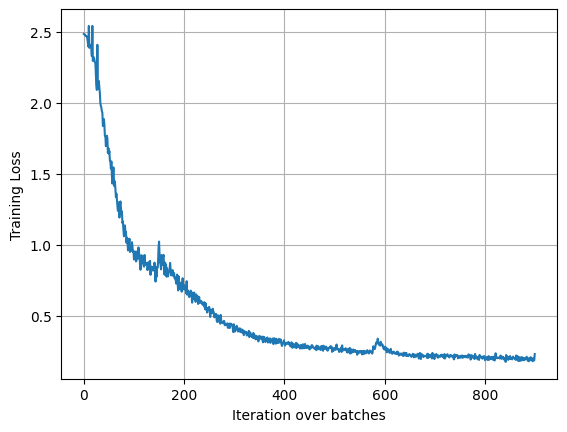

In [32]:
plt.plot(overall_training_loss)
plt.ylabel("Training Loss")
plt.xlabel("Iteration over batches")
plt.grid()

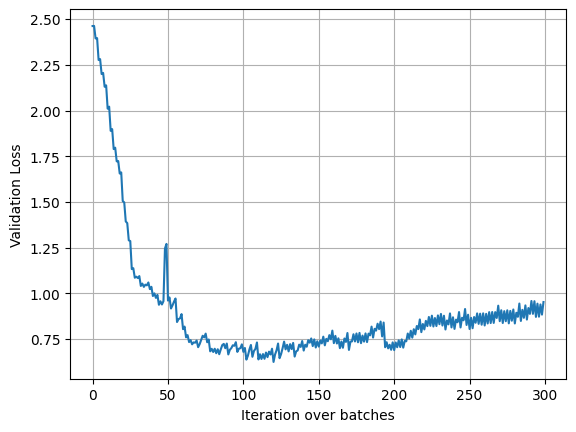

In [33]:
plt.plot(overall_validation_loss)
plt.ylabel("Validation Loss")
plt.xlabel("Iteration over batches")
plt.grid()

In [15]:
def get_images_and_segments_test_arrays():

  y_true_segments = []
  y_true_images = []
  test_count = 64

  ds = validation_dataset.unbatch()
  ds = ds.batch(101)

  for image, annotation in ds.take(1):
    y_true_images = image
    y_true_segments = annotation


  y_true_segments = y_true_segments[:test_count, : ,: , :]
  y_true_segments = np.argmax(y_true_segments, axis=3)

  return y_true_images, y_true_segments

y_true_images, y_true_segments = get_images_and_segments_test_arrays()

In [16]:
def compute_metrics(y_true, y_pred):


  class_wise_iou = []
  class_wise_dice_score = []

  smoothening_factor = 0.00001

  for i in range(12):
    intersection = np.sum((y_pred == i) * (y_true == i))
    y_true_area = np.sum((y_true == i))
    y_pred_area = np.sum((y_pred == i))
    combined_area = y_true_area + y_pred_area

    iou = (intersection + smoothening_factor) / (combined_area - intersection + smoothening_factor)
    class_wise_iou.append(iou)

    dice_score =  2 * ((intersection + smoothening_factor) / (combined_area + smoothening_factor))
    class_wise_dice_score.append(dice_score)

  return class_wise_iou, class_wise_dice_score

In [17]:

results = model.predict(validation_dataset, steps=10)


results = np.argmax(results, axis=3)

 2/10 [=====>........................] - ETA: 1:27

10/10 [==============================] - 29s 1s/step


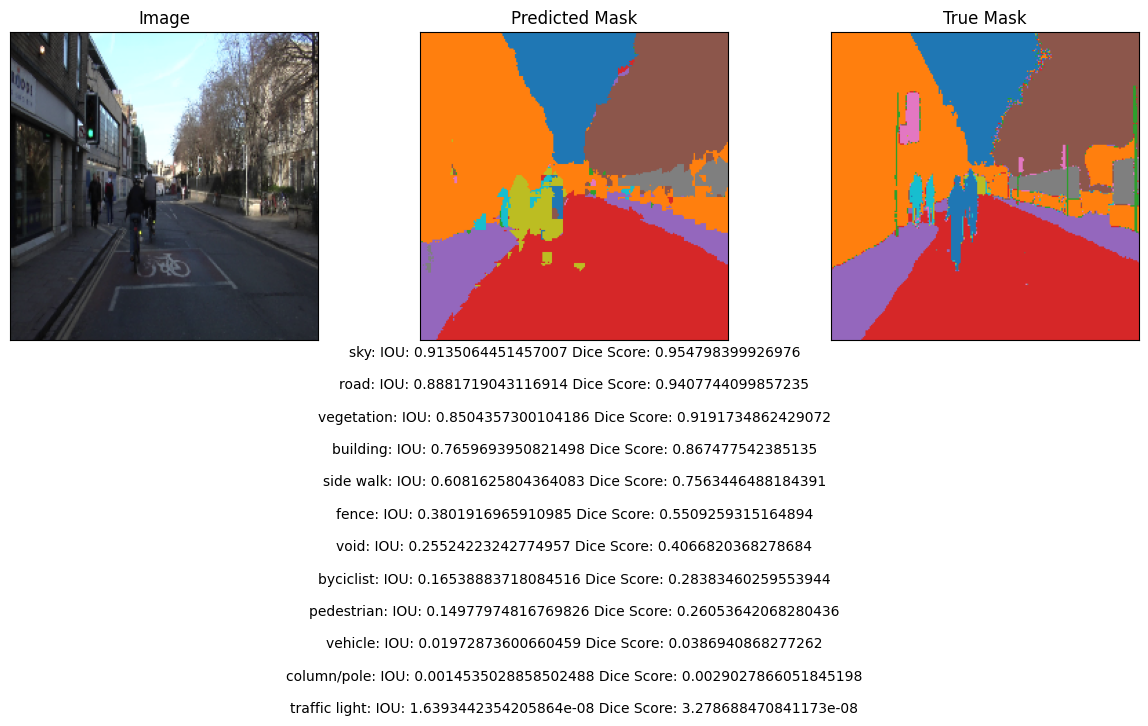

In [24]:
integer_slider = 0

iou, dice_score = compute_metrics(y_true_segments[integer_slider], results[integer_slider])


show_predictions(y_true_images[integer_slider], [results[integer_slider], y_true_segments[integer_slider]], ["Image", "Predicted Mask", "True Mask"], iou, dice_score)